In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [2]:
# get all data from csv files
diagnosis_data = pd.read_csv('Diagnosisdata.csv') 
hospital_data = pd.read_csv('Hospitaldata.csv') 
patient_data = pd.read_csv('Patientdata.csv') 

In [3]:
# merge all into single df
all_features = diagnosis_data.merge(hospital_data,on=['patientID','istrain']).merge(patient_data,on=['patientID','istrain'])

In [4]:
all_features.head()

,patientID,num_procedures,num_medications,num_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,...,Discharge_date,admission_type_id,admission_source_id,payer_code,medical_specialty,race,gender,age,weight,Target
0,PT456611,0,11,9,None,None,No,No,No,No,...,2015-05-07,1,1,PC8,NaN,type3,Female,[90-100),NaN,No
1,PT956824,1,6,6,None,None,No,No,No,No,...,2014-02-23,1,7,PC1,Oncology,type1,Male,[50-60),NaN,Yes
2,PT453330,2,27,9,None,None,No,No,No,No,...,2015-06-04,1,7,PC8,NaN,type3,Female,[80-90),NaN,No
3,PT677563,3,10,5,None,None,No,No,No,No,...,2015-12-20,2,1,NaN,Cardiology,type3,Female,[50-60),NaN,No
4,PT102924,6,12,9,None,None,No,No,No,No,...,2015-08-20,3,1,NaN,NaN,type3,Male,[60-70),NaN,Yes


In [5]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31513 entries, 0 to 31512
Data columns (total 41 columns):
patientID                  31513 non-null object
num_procedures             31513 non-null int64
num_medications            31513 non-null int64
num_diagnoses              31513 non-null int64
max_glu_serum              31513 non-null object
A1Cresult                  31513 non-null object
metformin                  31513 non-null object
repaglinide                31513 non-null object
nateglinide                31513 non-null object
chlorpropamide             31513 non-null object
glimepiride                31513 non-null object
acetohexamide              31513 non-null object
glipizide                  31513 non-null object
glyburide                  31513 non-null object
tolbutamide                31513 non-null object
pioglitazone               31513 non-null object
rosiglitazone              31513 non-null object
acarbose                   31513 non-null object
miglitol    

In [6]:
for col in all_features.columns:
    print(col)
    print(all_features[col].unique())

patientID
['PT456611' 'PT956824' 'PT453330' ... 'PT247544' 'PT610717' 'PT859520']
num_procedures
[0 1 2 3 6 5 4]
num_medications
[11  6 27 10 12  7 16  5 15 26 13  4 20 25 19  9 24 21 14 22 17  3 43  8
 18 31 23 28 35  2 60 46 30 33 34 38 29 48 37 39 32 41 55  1 42 51 53 45
 40 36 47 44 58 49 56 63 50 52 59 64 57 54 68 72 62 65 61 81 70 67]
num_diagnoses
[ 9  6  5  8  3  4  7  2  1 16 10 13 12 15 14]
max_glu_serum
['None' '>200' 'Norm' '>300']
A1Cresult
['None' '>8' 'Norm' '>7']
metformin
['No' 'Steady' 'Up' 'Down']
repaglinide
['No' 'Steady' 'Up' 'Down']
nateglinide
['No' 'Steady' 'Down' 'Up']
chlorpropamide
['No' 'Steady' 'Up' 'Down']
glimepiride
['No' 'Steady' 'Up' 'Down']
acetohexamide
['No']
glipizide
['No' 'Steady' 'Up' 'Down']
glyburide
['No' 'Steady' 'Up' 'Down']
tolbutamide
['No' 'Steady']
pioglitazone
['No' 'Steady' 'Up' 'Down']
rosiglitazone
['Steady' 'No' 'Up' 'Down']
acarbose
['No' 'Steady' 'Up']
miglitol
['No' 'Steady']
troglitazone
['No' 'Steady']
tolazamide
['No' 'Stead

In [7]:
# Observations:
# 1) AdmissionID is an identifier and does not have much impact on readmission
# 2) Weight, payer_code and medical_specialty features have missing values. As we have many features, we can drop 
# these feature columns

In [8]:
# admissionID is only identifier
all_features = all_features.drop(columns=['AdmissionID'])

In [9]:
# Dropping features with missing values:
all_features = all_features.drop(columns=['weight','payer_code','medical_specialty'])

In [10]:
# Admission Date and Discharge date can be converted to a single column to indicate number of days spent admitted
# combine admission date and discharge date cols to duration of stay

# converting type from object to datetime
date_list = ['Admission_date','Discharge_date']
for col in date_list:
    all_features[col] = all_features[col].astype('datetime64')

# getting number of days and dividing by np.timedelta64(1, 'D') to get int number of days 
all_features['duration_of_stay'] = all_features['Discharge_date'] - all_features['Admission_date']
all_features['duration_of_stay'] = all_features['duration_of_stay']/np.timedelta64(1, 'D')
# dropping Admission Date and Discharge date feature cols
all_features = all_features.drop(columns=date_list)

In [11]:
for col in all_features.columns:
    print(col)
    print(all_features[col].unique())

patientID
['PT456611' 'PT956824' 'PT453330' ... 'PT247544' 'PT610717' 'PT859520']
num_procedures
[0 1 2 3 6 5 4]
num_medications
[11  6 27 10 12  7 16  5 15 26 13  4 20 25 19  9 24 21 14 22 17  3 43  8
 18 31 23 28 35  2 60 46 30 33 34 38 29 48 37 39 32 41 55  1 42 51 53 45
 40 36 47 44 58 49 56 63 50 52 59 64 57 54 68 72 62 65 61 81 70 67]
num_diagnoses
[ 9  6  5  8  3  4  7  2  1 16 10 13 12 15 14]
max_glu_serum
['None' '>200' 'Norm' '>300']
A1Cresult
['None' '>8' 'Norm' '>7']
metformin
['No' 'Steady' 'Up' 'Down']
repaglinide
['No' 'Steady' 'Up' 'Down']
nateglinide
['No' 'Steady' 'Down' 'Up']
chlorpropamide
['No' 'Steady' 'Up' 'Down']
glimepiride
['No' 'Steady' 'Up' 'Down']
acetohexamide
['No']
glipizide
['No' 'Steady' 'Up' 'Down']
glyburide
['No' 'Steady' 'Up' 'Down']
tolbutamide
['No' 'Steady']
pioglitazone
['No' 'Steady' 'Up' 'Down']
rosiglitazone
['Steady' 'No' 'Up' 'Down']
acarbose
['No' 'Steady' 'Up']
miglitol
['No' 'Steady']
troglitazone
['No' 'Steady']
tolazamide
['No' 'Stead

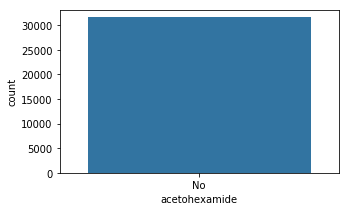

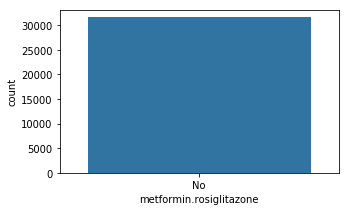

In [12]:
# From above observations, we can see that acetohexamide and metformin.rosiglitazone have same value for all samples
for col in ['acetohexamide','metformin.rosiglitazone']:
    plt.figure(figsize=(5,3))
    sns.countplot(x=all_features[col])
    plt.show();

In [13]:
# acetohexamide and metformin.rosiglitazone have same value for all samples. So it can be skipped from feature selection
all_features = all_features.drop(columns=['acetohexamide','metformin.rosiglitazone'])

In [14]:
# creating a col number_of_changes to represent number of times changes were made in prescribing drugs to a patient
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone','tolazamide', 'insulin', 'glyburide.metformin', 'glipizide.metformin', 'metformin.pioglitazone']

all_features['number_of_changes'] = 0

# create temp columns for each key and get value of number of changes
for col in keys:
    colname = str(col) + 'temp'
    all_features[colname] = all_features[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
    all_features['number_of_changes'] = all_features['number_of_changes'] + all_features[colname]
    all_features = all_features.drop(columns=colname)

In [15]:
# dropping columns from which number_of_changes was created
all_features = all_features.drop(columns=keys)

In [16]:
all_features.columns

Index(['patientID', 'num_procedures', 'num_medications', 'num_diagnoses',
       'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'istrain',
       'admission_type_id', 'admission_source_id', 'race', 'gender', 'age',
       'Target', 'duration_of_stay', 'number_of_changes'],
      dtype='object')

In [17]:
high_cardinality =['num_medications', 'num_diagnoses', 'admission_source_id', 'duration_of_stay','age']

In [18]:
# types of features
nominal = ['max_glu_serum','A1Cresult','race','age']
binary = ['gender','change','diabetesMed']

In [19]:
# label encoding nominal features
le = LabelEncoder()

for col in nominal:
    all_features[col] = le.fit_transform(all_features[col])

In [20]:
# get dummies for binary features
all_features[binary] = pd.get_dummies(all_features[binary],columns=binary,drop_first=True)

In [21]:
all_features.head()

,patientID,num_procedures,num_medications,num_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,istrain,admission_type_id,admission_source_id,race,gender,age,Target,duration_of_stay,number_of_changes
0,PT456611,0,11,9,2,2,0,1,1,1,1,2,0,9,No,3.0,0
1,PT956824,1,6,6,2,2,1,0,1,1,7,0,1,5,Yes,3.0,0
2,PT453330,2,27,9,2,2,1,0,1,1,7,2,0,8,No,3.0,0
3,PT677563,3,10,5,2,2,1,1,1,2,1,2,0,5,No,2.0,0
4,PT102924,6,12,9,2,2,1,0,1,3,1,2,1,6,Yes,1.0,0


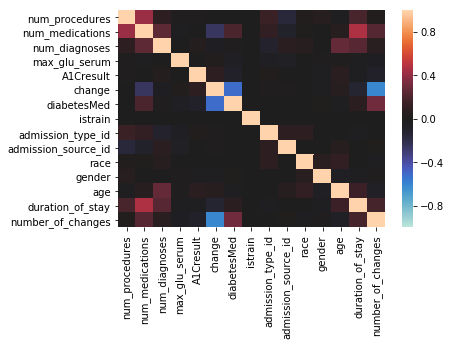

In [22]:
# correlation heatmap
corr = all_features.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0)
sns.set(rc={'figure.figsize':(11,11)})

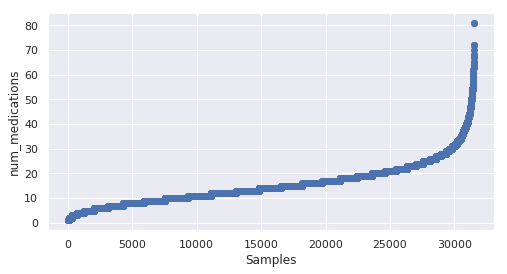

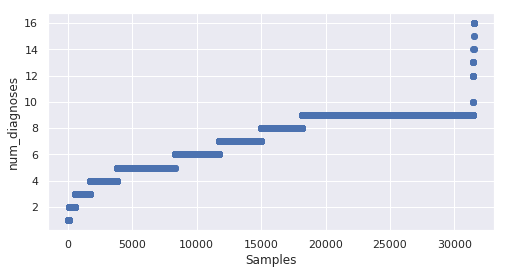

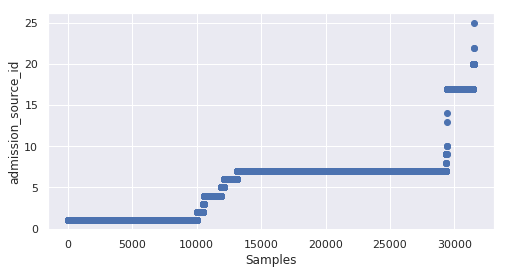

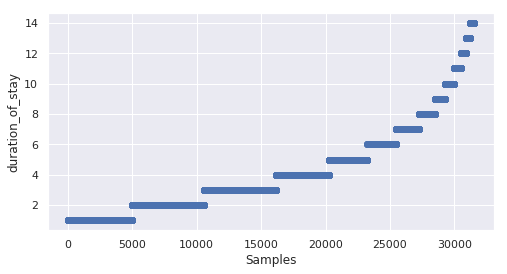

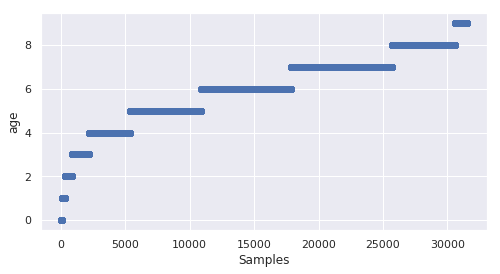

In [23]:
# high_cardinality
for y in high_cardinality:
    plt.figure(figsize=(8,4))
    plt.scatter(range(all_features.shape[0]), np.sort(all_features[y].values))
    plt.xlabel('Samples')
    plt.ylabel(y)
    plt.show();

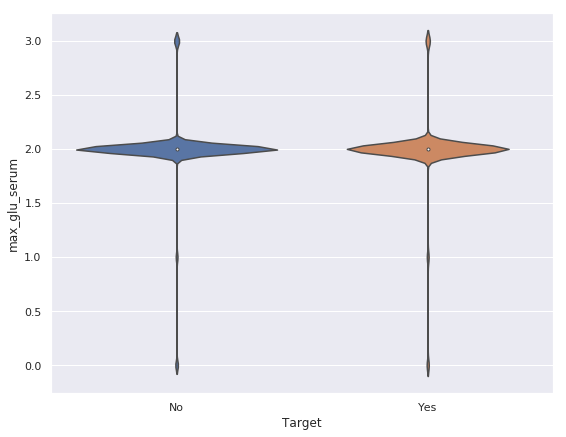

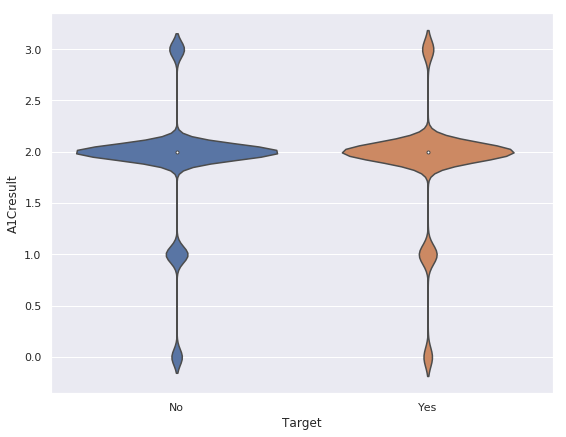

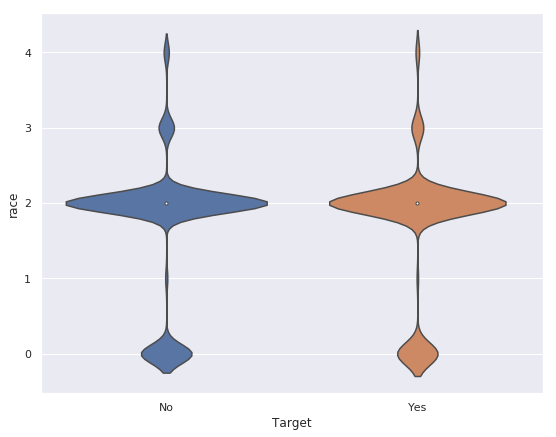

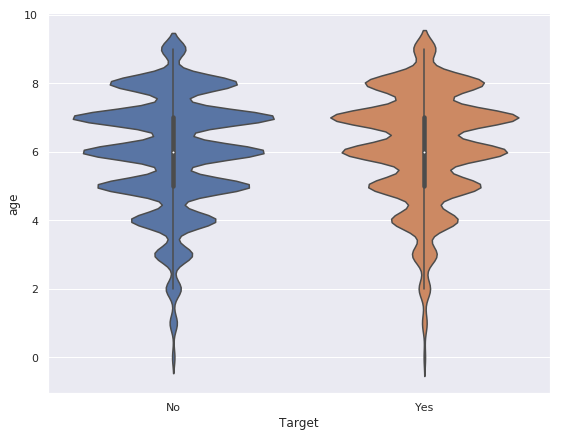

In [24]:
# nominal:
for y in nominal:
    plt.figure(figsize=(9,7))
    sns.violinplot(x=all_features.Target, y=y, data=all_features)
    plt.xlabel('Target', fontsize=12)
    plt.ylabel(y, fontsize=12)
    plt.show();

In [25]:
all_train_features = all_features[all_features['istrain']==1]
all_test_features = all_features[all_features['istrain']==0]
all_train_features = all_train_features.drop(columns='istrain')
all_test_features = all_test_features.drop(columns='istrain')

In [26]:
# Use Random over sampling to handle Target imbalance
target_count = all_train_features['Target'].value_counts()
print(target_count)
print('No:', target_count[0])
print('Yes', target_count[1])

# Sampling for target imbalance:
# Get Class counts
# count_class_0 = No; count_class_1 = Yes
count_class_0, count_class_1 = all_features['Target'].value_counts()

# Divide by class
df_class_0 = all_features[all_features['Target'] == 'No']
df_class_1 = all_features[all_features['Target'] == 'Yes']

# Random Over-sampling:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Target.value_counts())

df_test_over = df_test_over.drop(columns='istrain')
all_train_features = df_test_over

No     17786
Yes     6470
Name: Target, dtype: int64
No: 17786
Yes 6470
Random over-sampling:
Yes    17786
No     17786
Name: Target, dtype: int64


In [27]:
# Encode Target Feature
lb = LabelBinarizer()
all_train_features['Target'] = lb.fit_transform(all_train_features['Target'])

In [28]:
# all_train_data.columns
X = all_train_features.drop(columns=['patientID','Target'])
y = all_train_features['Target']

all_test_features = all_test_features.drop(columns='Target')

In [29]:
# method to plot roc curve
def plot_roc_curve(fpr, tpr): 
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

KNeighborsClassifier
AUC is 0.78
Precision is 0.68
Recall is 0.84


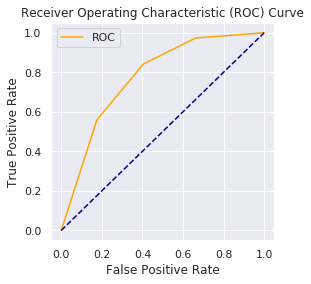

DecisionTreeClassifier
AUC is 0.84
Precision is 0.77
Recall is 0.95


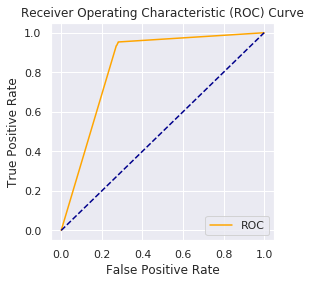

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier
AUC is 0.94
Precision is 0.85
Recall is 0.92


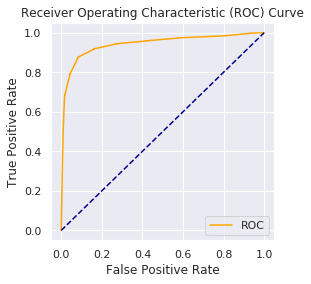

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression
AUC is 0.56
Precision is 0.53
Recall is 0.55


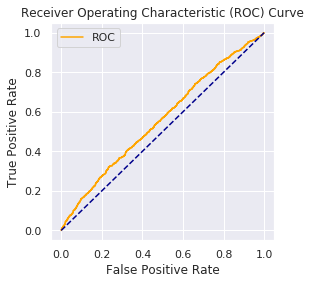

AdaBoostClassifier
AUC is 0.57
Precision is 0.55
Recall is 0.58


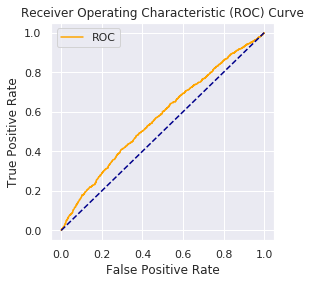

GradientBoostingClassifier
AUC is 0.59
Precision is 0.56
Recall is 0.62


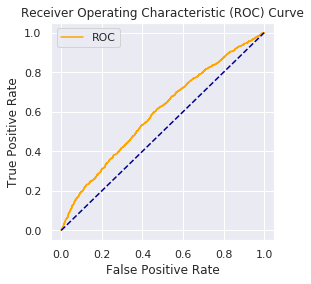

GaussianNB
AUC is 0.56
Precision is 0.54
Recall is 0.55


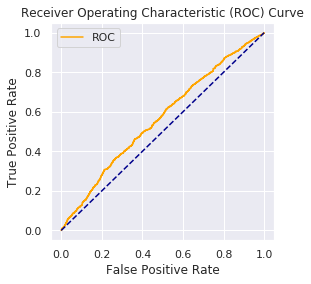

KNeighborsClassifier
AUC is 0.80
Precision is 0.68
Recall is 0.86


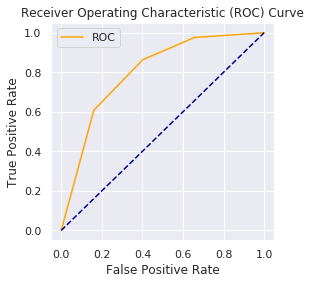

DecisionTreeClassifier
AUC is 0.82
Precision is 0.76
Recall is 0.94


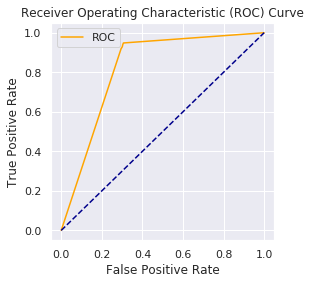

RandomForestClassifier
AUC is 0.94
Precision is 0.86
Recall is 0.92


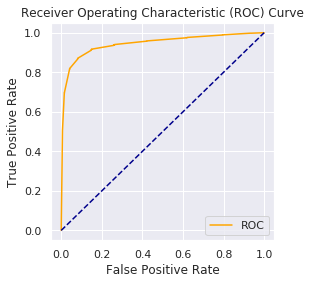

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression
AUC is 0.56
Precision is 0.53
Recall is 0.54


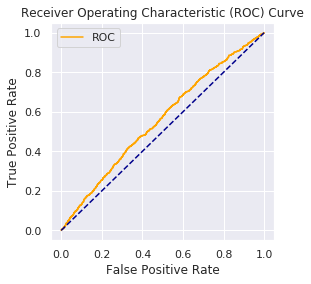

AdaBoostClassifier
AUC is 0.57
Precision is 0.53
Recall is 0.54


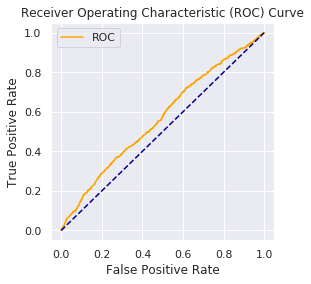

GradientBoostingClassifier
AUC is 0.60
Precision is 0.56
Recall is 0.60


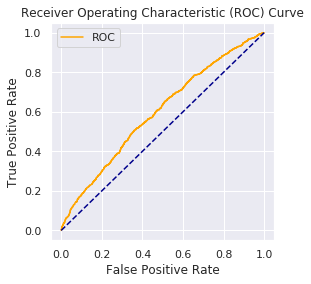

GaussianNB
AUC is 0.56
Precision is 0.54
Recall is 0.55


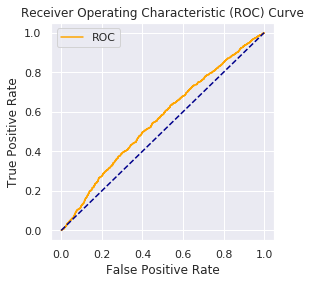

KNeighborsClassifier
AUC is 0.80
Precision is 0.68
Recall is 0.85


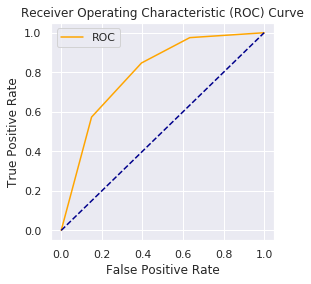

DecisionTreeClassifier
AUC is 0.82
Precision is 0.76
Recall is 0.93


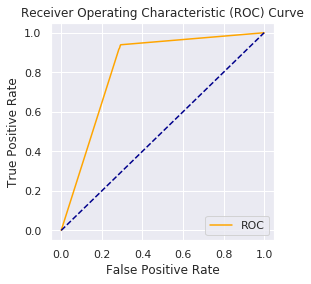

RandomForestClassifier
AUC is 0.94
Precision is 0.85
Recall is 0.91


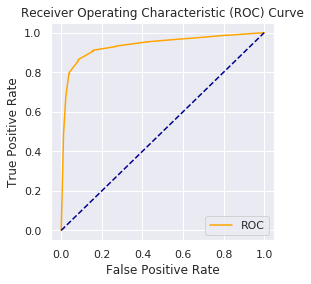

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression
AUC is 0.55
Precision is 0.52
Recall is 0.54


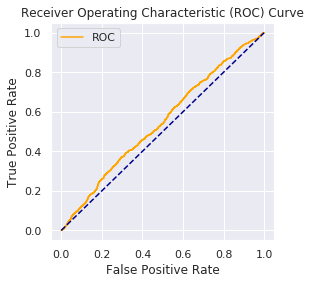

AdaBoostClassifier
AUC is 0.55
Precision is 0.54
Recall is 0.57


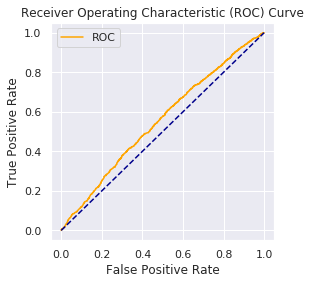

GradientBoostingClassifier
AUC is 0.57
Precision is 0.53
Recall is 0.59


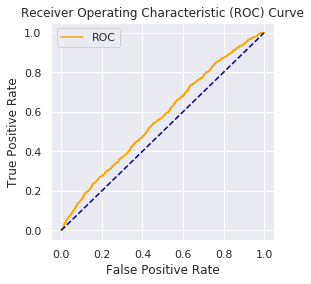

GaussianNB
AUC is 0.54
Precision is 0.53
Recall is 0.54


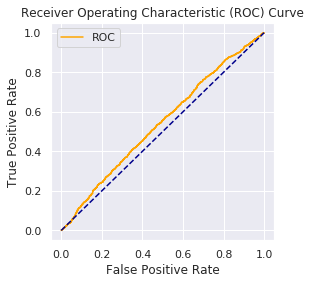

KNeighborsClassifier
AUC is 0.78
Precision is 0.67
Recall is 0.84


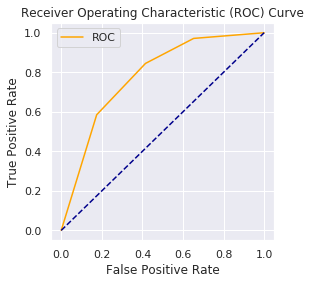

DecisionTreeClassifier
AUC is 0.82
Precision is 0.76
Recall is 0.93


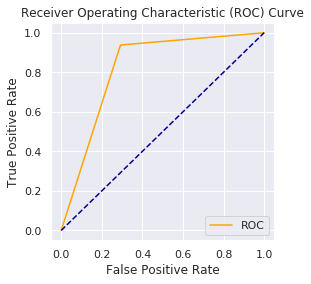

RandomForestClassifier
AUC is 0.94
Precision is 0.86
Recall is 0.91


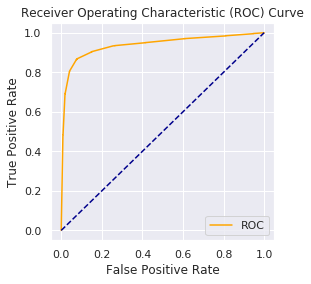

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression
AUC is 0.55
Precision is 0.53
Recall is 0.56


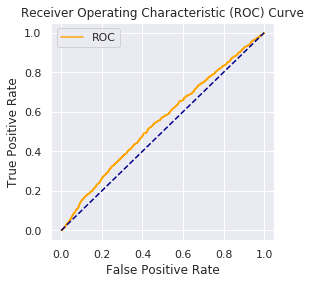

AdaBoostClassifier
AUC is 0.56
Precision is 0.54
Recall is 0.56


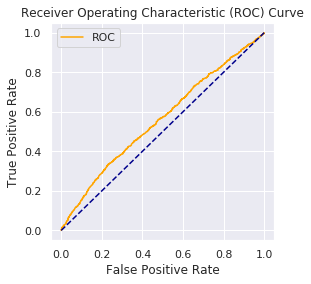

GradientBoostingClassifier
AUC is 0.59
Precision is 0.56
Recall is 0.61


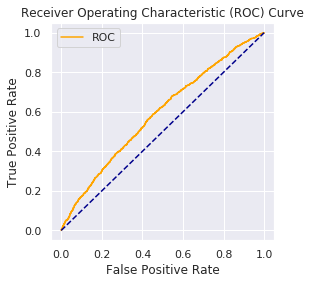

GaussianNB
AUC is 0.55
Precision is 0.53
Recall is 0.55


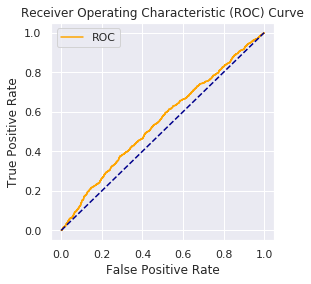

KNeighborsClassifier
AUC is 0.80
Precision is 0.68
Recall is 0.85


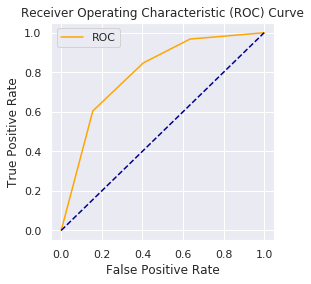

DecisionTreeClassifier
AUC is 0.83
Precision is 0.77
Recall is 0.93


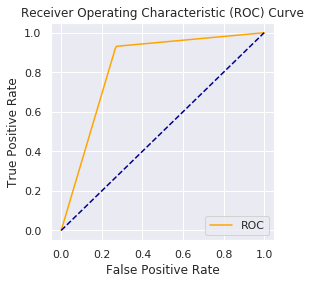

RandomForestClassifier
AUC is 0.93
Precision is 0.85
Recall is 0.90


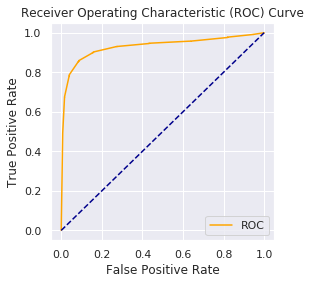

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression
AUC is 0.55
Precision is 0.54
Recall is 0.52


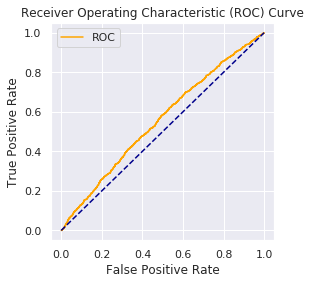

AdaBoostClassifier
AUC is 0.56
Precision is 0.54
Recall is 0.55


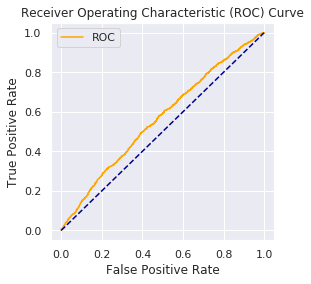

GradientBoostingClassifier
AUC is 0.58
Precision is 0.55
Recall is 0.57


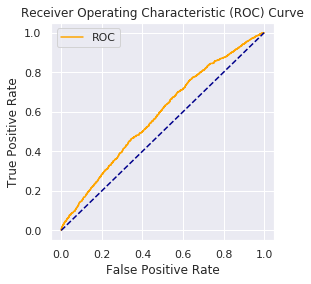

GaussianNB
AUC is 0.55
Precision is 0.53
Recall is 0.51


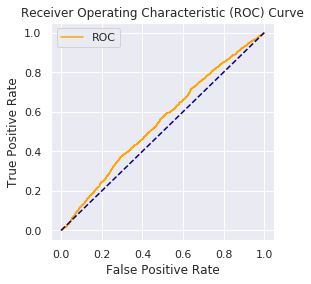

KNeighborsClassifier
AUC is 0.80
Precision is 0.68
Recall is 0.86


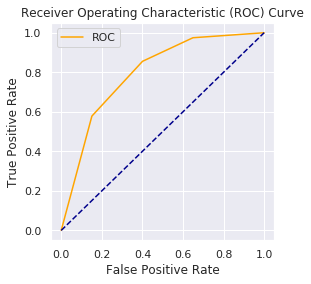

DecisionTreeClassifier
AUC is 0.83
Precision is 0.77
Recall is 0.93


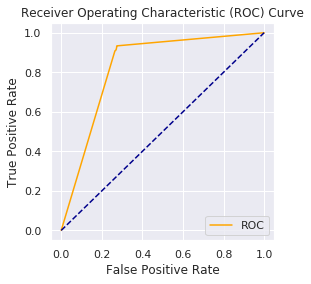

RandomForestClassifier
AUC is 0.94
Precision is 0.86
Recall is 0.91


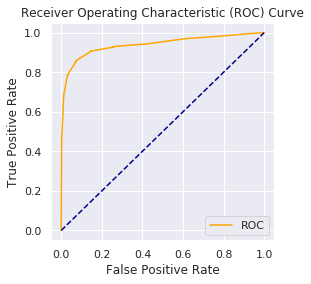

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression
AUC is 0.56
Precision is 0.54
Recall is 0.56


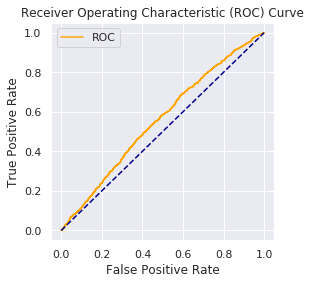

AdaBoostClassifier
AUC is 0.57
Precision is 0.55
Recall is 0.58


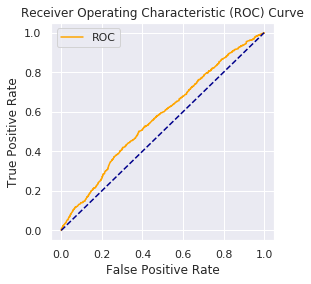

GradientBoostingClassifier
AUC is 0.59
Precision is 0.56
Recall is 0.61


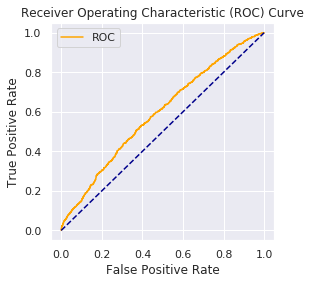

GaussianNB
AUC is 0.56
Precision is 0.54
Recall is 0.57


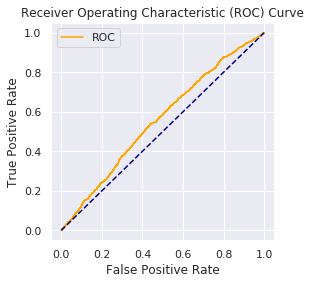

KNeighborsClassifier
AUC is 0.78
Precision is 0.67
Recall is 0.84


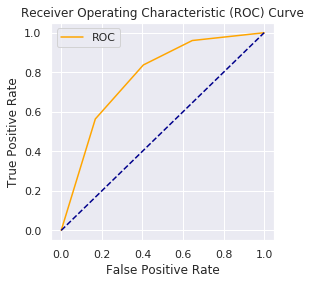

DecisionTreeClassifier
AUC is 0.81
Precision is 0.75
Recall is 0.92


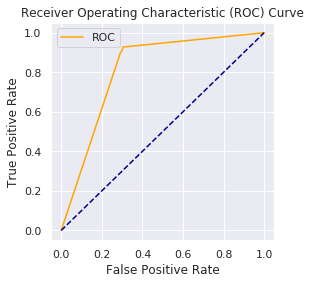

RandomForestClassifier
AUC is 0.93
Precision is 0.86
Recall is 0.89


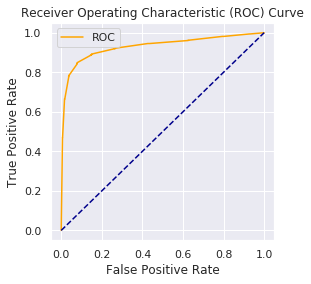

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression
AUC is 0.55
Precision is 0.53
Recall is 0.53


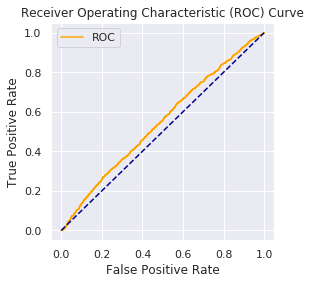

AdaBoostClassifier
AUC is 0.55
Precision is 0.53
Recall is 0.54


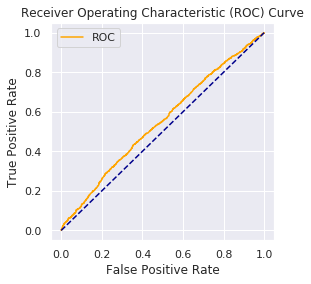

GradientBoostingClassifier
AUC is 0.57
Precision is 0.54
Recall is 0.58


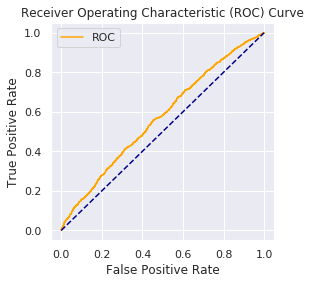

GaussianNB
AUC is 0.54
Precision is 0.52
Recall is 0.52


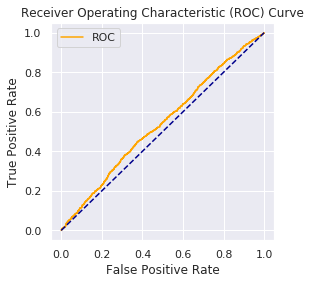

KNeighborsClassifier
AUC is 0.79
Precision is 0.68
Recall is 0.84


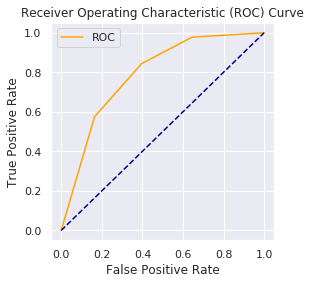

DecisionTreeClassifier
AUC is 0.83
Precision is 0.77
Recall is 0.94


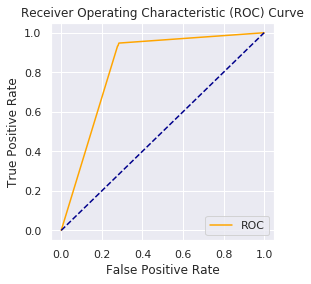

RandomForestClassifier
AUC is 0.94
Precision is 0.86
Recall is 0.91


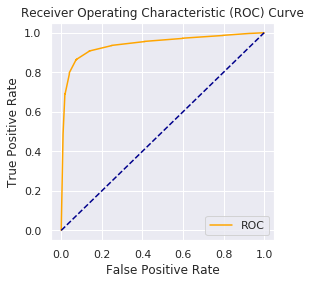

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression
AUC is 0.56
Precision is 0.54
Recall is 0.54


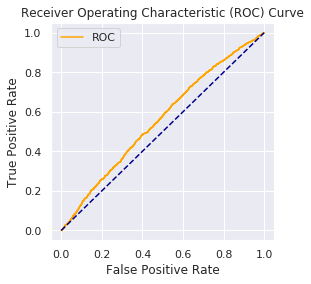

AdaBoostClassifier
AUC is 0.57
Precision is 0.55
Recall is 0.57


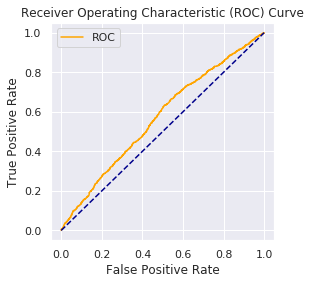

GradientBoostingClassifier
AUC is 0.60
Precision is 0.56
Recall is 0.61


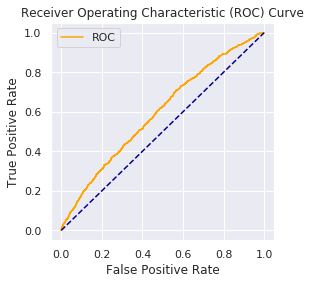

GaussianNB
AUC is 0.55
Precision is 0.54
Recall is 0.54


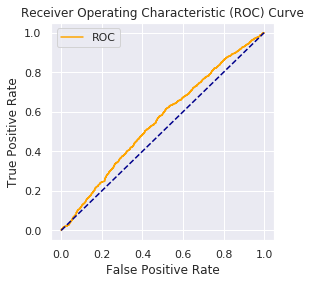

KNeighborsClassifier
AUC is 0.79
Precision is 0.68
Recall is 0.84


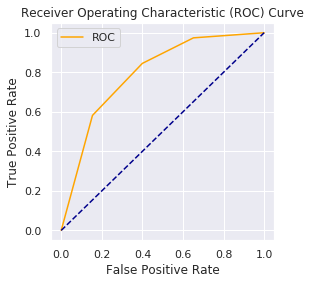

DecisionTreeClassifier
AUC is 0.83
Precision is 0.77
Recall is 0.93


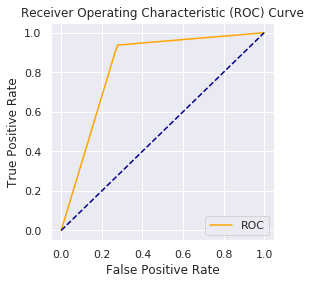

RandomForestClassifier
AUC is 0.93
Precision is 0.85
Recall is 0.90


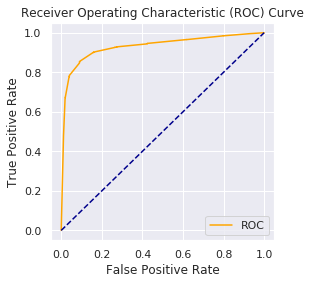

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression
AUC is 0.56
Precision is 0.54
Recall is 0.56


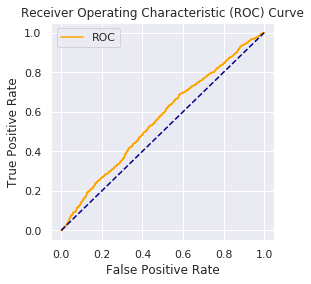

AdaBoostClassifier
AUC is 0.57
Precision is 0.55
Recall is 0.58


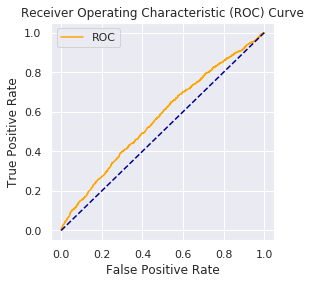

GradientBoostingClassifier
AUC is 0.59
Precision is 0.56
Recall is 0.63


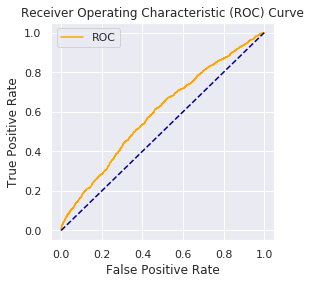

GaussianNB
AUC is 0.55
Precision is 0.53
Recall is 0.54


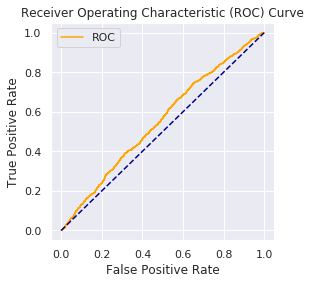

KNeighborsClassifier
AUC is 0.79
Precision is 0.68
Recall is 0.86


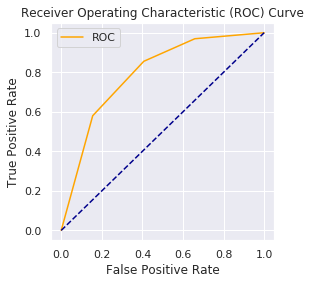

DecisionTreeClassifier
AUC is 0.82
Precision is 0.76
Recall is 0.93


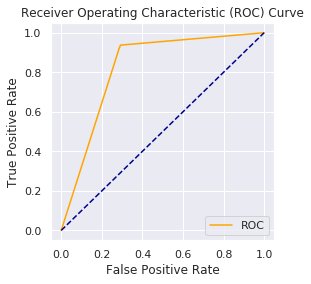

RandomForestClassifier
AUC is 0.94
Precision is 0.86
Recall is 0.91


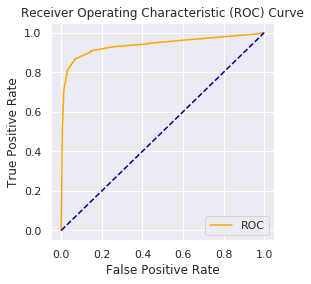

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression
AUC is 0.56
Precision is 0.53
Recall is 0.55


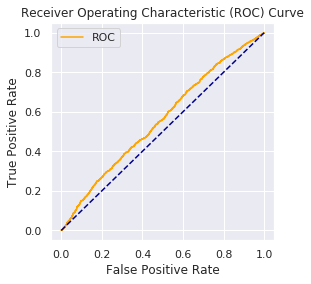

AdaBoostClassifier
AUC is 0.57
Precision is 0.54
Recall is 0.57


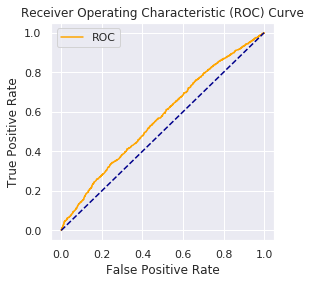

GradientBoostingClassifier
AUC is 0.59
Precision is 0.56
Recall is 0.61


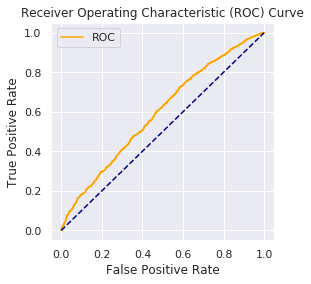

GaussianNB
AUC is 0.55
Precision is 0.53
Recall is 0.54


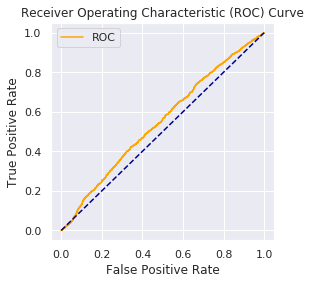

In [30]:
"""
Model evaluation across multiple classifiers based on accuracy of predictions.
"""
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()]

# add all accuracy scores into dict
acc_dict = {}

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

# sss.split gives lists of train and test indexes. iloc is done to get those rows from dataframe and store in train and test dataframes 
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for clf in classifiers:
        # train the model and predict
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        
        # get ROC,AUC,Precision,Recall scores
        probs = clf.predict_proba(X_test)
        probs = probs[:, 1]
        print(name)
        print("AUC is {0:.2f}".format(roc_auc_score(y_test, probs)))
        print("Precision is {0:.2f}".format(precision_score(y_test, train_predictions)))
        print("Recall is {0:.2f}".format(recall_score(y_test, train_predictions)))
        
        # plot ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, probs)  
        plot_roc_curve(fpr, tpr) 
        
        # combine accuracies from all splits to get final accuracy score
        if name in acc_dict:
            acc_dict[name] += (acc/10.0)
        else:
            acc_dict[name] = (acc/10.0)

In [31]:
acc_dict

{'KNeighborsClassifier': 0.722512647554806,
 'DecisionTreeClassifier': 0.8238898257448005,
 'RandomForestClassifier': 0.8770095559302978,
 'LogisticRegression': 0.5344856661045531,
 'AdaBoostClassifier': 0.5427206295671726,
 'GradientBoostingClassifier': 0.5592748735244519,
 'GaussianNB': 0.5349634626194492}

In [32]:
# Random forest classifier gives the highest accuracy as seen from above scores
# It is used to predict for the test features and output is stored in dataframe
clf = RandomForestClassifier()
clf.fit(X,y)
predictions = clf.predict(all_test_features[all_test_features.columns[1:]])

output=pd.DataFrame({'patientID':all_test_features['patientID'],'Target':predictions})

/home/divyanallamalli/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [33]:
# decode Target feature
output['Target'] = lb.inverse_transform(output['Target'])

In [34]:
output.head()

,patientID,Target
24256,PT456611,No
24257,PT956824,Yes
24258,PT453330,No
24259,PT677563,No
24260,PT102924,Yes


In [35]:
output.to_csv('sampleSubmission.csv',index=False)